# CS 440/540 Machine Learning in Finance: Homework 1

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW1.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 440 or CS 540).

Problems on homework assignments are equally weighted. `The Challenge Question is required for CS 540 students and optional for all others.`

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import all libraries here

In [8]:
#Import libraries before starting
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm
from sklearn.manifold import TSNE

## Problem 1: Mean-Variance Portfolio Optimization

In this problem, we will be implementing a simple Mean-Variance portfolio optimization on S&P 500 index constituent stocks between 2015-2017. We will simply be training the optimizer between 2015-2016, and testing it on between 2016 and 2017. 

We assume that stocks can only be long, and all portfolio should be allocated to stocks (We cannot hold cash).

You need to use cvxpy library to formulate and solve optimization problem. You can obtain the stock price data by Yahoo Finance library(yfinance). You can find SP 500 constiuent indices in sp500tickers.txt file.

Run portfolio optimization for range of lambdas (which is for modeling the relative weight of variance with respect to return): [0.1, 1.0, 5.0, 10.0]. Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period. Discuss which alpha value performs the best. Why?

In [2]:
failed_tickers = ['PEAK', 'FLT', 'PXD', 'WRK'] # I downloaded the data from yahoo finance but those four failed and I thought that problem can be the data

In [3]:
def read_and_clean_tickers(dir, failed_tickers): # I cleaned the tickers from failure ones
    with open(dir, 'r') as file:
        tickers = file.readlines()
    
    cleaned_tickers = [ticker.strip() for ticker in tickers if ticker.strip() not in failed_tickers]
    return cleaned_tickers

In [4]:
# We need to read sp500 tickers
def read_tickers(dir):
    with open(dir, 'r') as file:
        tickers = file.readlines()
        return tickers

In [5]:
tickers = read_and_clean_tickers("sp500tickers.txt", failed_tickers)

In [6]:
print(len(tickers))

481


In [7]:
def append_tickers(tickers): # append all tickers as a stock
    all_tickers = []
    for ticker in tickers:
        all_tickers.append(ticker.strip()) 
        print(all_tickers)
    return all_tickers

In [10]:
stocks = append_tickers(tickers=tickers)

['EQIX']
['EQIX', 'STLD']
['EQIX', 'STLD', 'GPC']
['EQIX', 'STLD', 'GPC', 'BKNG']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET', 'LVS']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET', 'LVS', 'PCG']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET', 'LVS', 'PCG', 'FAST']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET', 'LVS', 'PCG', 'FAST', 'GLW']
['EQIX', 'STLD', 'GPC', 'BKNG', 'CSX', 'AON', 'BLK', 'TJX', 'IRM', 'ELV', 'ANET', 'LVS', 'PCG', '

In [11]:
# specify the times for yahoo finance, download data
train_start_date = "2015-01-01"
train_end_date = "2016-12-31"
test_start_date = train_end_date
test_end_date = "2017-12-31"

In [12]:
# download the close prices for portfolio optimization
train_data = yfinance.download(stocks, start=train_start_date, end=train_end_date)['Close']
test_data = yfinance.download(stocks, start=train_end_date, end=test_end_date)['Close']

[*********************100%***********************]  481 of 481 completed
[*********************100%***********************]  481 of 481 completed


In [13]:
print(train_data.head())

Ticker                             A        AAL       AAPL       ABBV  \
Date                                                                    
2015-01-02 00:00:00+00:00  40.560001  53.910000  27.332500  65.889999   
2015-01-05 00:00:00+00:00  39.799999  53.880001  26.562500  64.650002   
2015-01-06 00:00:00+00:00  39.180000  53.040001  26.565001  64.330002   
2015-01-07 00:00:00+00:00  39.700001  53.009998  26.937500  66.930000   
2015-01-08 00:00:00+00:00  40.889999  53.660000  27.972500  67.629997   

Ticker                           ABT       ACGL        ACN       ADBE  \
Date                                                                    
2015-01-02 00:00:00+00:00  44.900002  19.496668  88.839996  72.339996   
2015-01-05 00:00:00+00:00  44.910000  19.379999  87.339996  71.980003   
2015-01-06 00:00:00+00:00  44.400002  19.423332  86.709999  70.529999   
2015-01-07 00:00:00+00:00  44.759998  19.536667  88.529999  71.110001   
2015-01-08 00:00:00+00:00  45.680000  19.876667  8

In [14]:
print(test_data.head())

Ticker                             A        AAL       AAPL       ABBV  \
Date                                                                    
2017-01-03 00:00:00+00:00  46.490002  46.299999  29.037500  62.410000   
2017-01-04 00:00:00+00:00  47.099998  46.700001  29.004999  63.290001   
2017-01-05 00:00:00+00:00  46.540001  45.889999  29.152500  63.770000   
2017-01-06 00:00:00+00:00  47.990002  46.209999  29.477501  63.790001   
2017-01-09 00:00:00+00:00  48.139999  47.080002  29.747499  64.209999   

Ticker                           ABT       ACGL         ACN        ADBE  \
Date                                                                      
2017-01-03 00:00:00+00:00  39.049999  28.629999  116.459999  103.480003   
2017-01-04 00:00:00+00:00  39.360001  28.833332  116.739998  104.139999   
2017-01-05 00:00:00+00:00  39.700001  28.540001  114.989998  105.910004   
2017-01-06 00:00:00+00:00  40.779999  28.823334  116.300003  108.300003   
2017-01-09 00:00:00+00:00  40.740002  

In [15]:
len(train_data), len(test_data)

(504, 251)

In [16]:
# control the na values in train data
nan_count_train = train_data.isnull().sum()
print("NaN values per stock before filling:")
print(nan_count_train[nan_count_train > 0])

NaN values per stock before filling:
Ticker
ETSY     71
FTV     378
HPE     200
HWM     462
KHC     126
LW      469
PYPL    126
SEDG     57
dtype: int64


In [17]:
# control the na values in test data
nan_count_test = test_data.isnull().sum()
print("NaN values per stock before filling:")
print(nan_count_test[nan_count_test > 0])

NaN values per stock before filling:
Series([], dtype: int64)


In [26]:
# fill the na values with mean
train_data = train_data.fillna(train_data.mean()).copy() # there is warning if I didn't write copy about the pandas frame
test_data = test_data.fillna(test_data.mean()).copy()

In [19]:
print(f"Total NaN values in training data after filling: {train_data.isnull().sum().sum()}")

Total NaN values in training data after filling: 1889


In [20]:
print(f"Total NaN values in testing data after filling: {test_data.isnull().sum().sum()}")

Total NaN values in testing data after filling: 0


In [21]:
# calculate the return values for both train and test set after filling the na values
train_returns = train_data.pct_change(fill_method=None).dropna()# if I don't use iloc, the first row filled with NA's
test_returns = test_data.pct_change(fill_method=None).dropna() # if I don't use iloc, the first row filled with NA's

In [22]:
print("Shape of training returns:", train_returns.shape)

Shape of training returns: (34, 481)


In [23]:
train_returns.head()

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-11 00:00:00+00:00,-0.014034,0.014894,0.005937,-0.014063,-0.011574,0.013873,-0.009557,-0.003843,0.016654,-0.076361,...,-0.003751,0.004137,-0.015853,-0.014080,0.000190,-0.010434,-0.026321,-0.019067,0.010109,-0.009395
2016-11-14 00:00:00+00:00,-0.022428,0.010948,-0.025085,-0.002060,-0.023418,0.003205,-0.016194,-0.012153,0.017453,0.027558,...,-0.005531,-0.008496,-0.004552,-0.025573,0.009289,0.000000,-0.000408,-0.001047,0.039491,-0.032602
2016-11-15 00:00:00+00:00,0.001544,0.031336,0.013244,-0.001588,0.015561,-0.003441,-0.010746,0.012107,0.026332,0.014226,...,0.027926,0.019216,0.018058,0.021984,0.028362,0.000000,0.035310,0.129472,0.008587,0.003881
2016-11-16 00:00:00+00:00,0.017181,-0.006926,0.026888,-0.021155,0.003517,-0.008631,0.011467,0.004052,-0.004838,-0.005289,...,-0.003453,-0.006115,-0.012324,0.010005,-0.007306,-0.004942,-0.005619,-0.033263,-0.033540,-0.006307
2016-11-17 00:00:00+00:00,-0.005197,0.031046,-0.000364,0.002600,0.011014,0.002488,0.008950,0.016622,0.004862,-0.006010,...,0.044704,-0.000256,-0.006064,0.006274,-0.006256,0.005960,-0.000793,0.013571,0.012013,0.007576


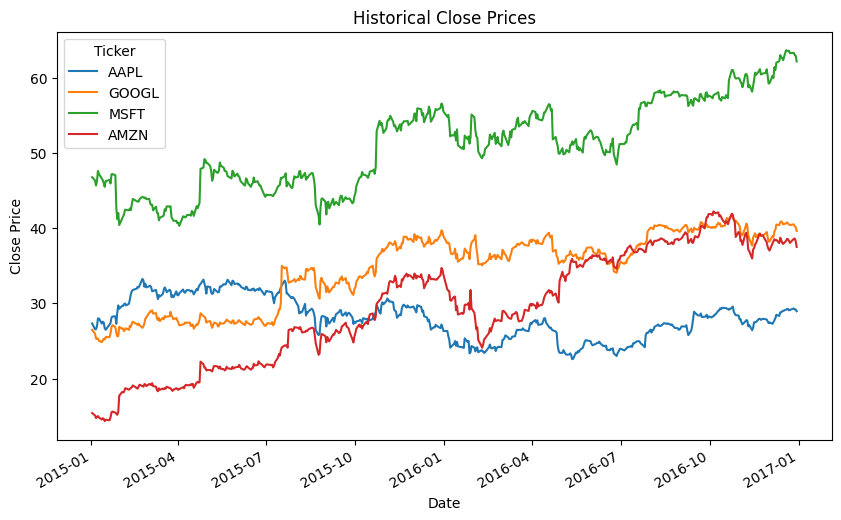

In [24]:
# For better understanding, I visualize the clos prices for some of the etf's
train_data[['AAPL', 'GOOGL', 'MSFT', 'AMZN']].plot(figsize=(10, 6))
plt.title('Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

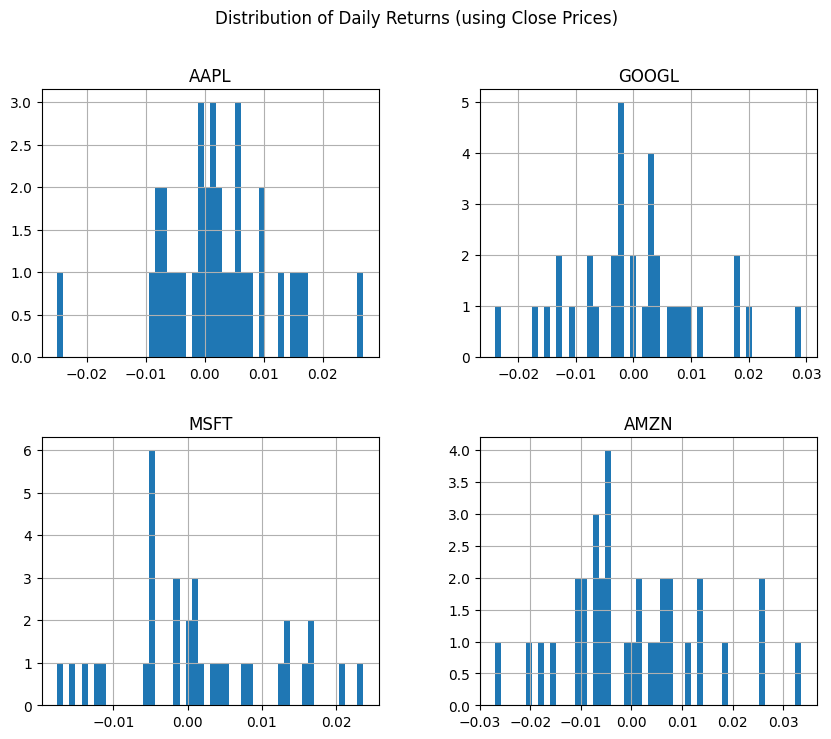

In [25]:
# For better understanding, I visualize some of the etf's daily returns dist
train_returns[['AAPL', 'GOOGL', 'MSFT', 'AMZN']].hist(bins=50, figsize=(10, 8))
plt.suptitle('Distribution of Daily Returns (using Close Prices)')
plt.show()

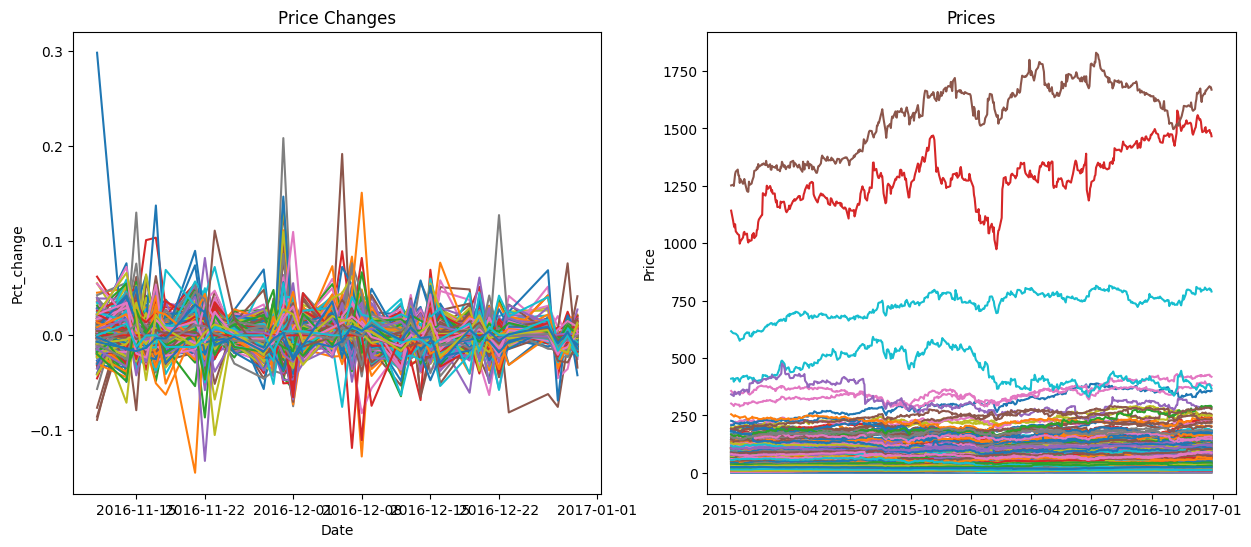

<Figure size 1000x600 with 0 Axes>

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plt.figure(figsize=(10, 6))

for t in range(len(stocks)):
    axs[0].plot(train_returns[stocks[t]], label=stocks[t])
for t in range(len(stocks)):
    axs[1].plot(train_data[stocks[t]], label=stocks[t])
axs[0].set_title('Price Changes')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Pct_change')
axs[1].set_title('Prices')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
plt.tight_layout()
plt.show()

In [28]:
def mean_variance_optimization(returns_train, alpha):

    # calculate mean of return values
    mean_returns = returns_train.mean()
    # calculate covariance matrix
    cov_matrix = cp.psd_wrap(returns_train.cov()) 
    
    # definition of optimization weights
    num_assets = len(mean_returns)
    weights = cp.Variable(num_assets)
    
    # portfolio objective : maximize return - risk weight * variance
    portfolio_return = weights.T @ mean_returns
    portfolio_risk = cp.quad_form(weights, cov_matrix)

    # maximize retun - alpha (risk weight) * risk (variance)
    objective = cp.Maximize(portfolio_return - alpha * portfolio_risk)

    # weights should be add to one and long only (weights >= 0)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    
    # solve the optimization 
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return weights.value


In [29]:
def calculate_portfolio_performance(weights, returns_test):
    portfolio_returns = np.dot(returns_test, weights)
    
    # calculate volatility which is standard deviation
    volatility = np.std(portfolio_returns)

    # calculate information ratio (mean return / volatility)
    ir = np.mean(portfolio_returns) / volatility
    
    return portfolio_returns, ir


In [30]:
def plot_pnl_curves(alphas, pnl_curves):
    plt.figure(figsize=(10, 6))
    for i, alpha in enumerate(alphas):
        if alpha == 0.1:
            plt.plot(pnl_curves[i], label=f'Alpha = {alpha}', linestyle='--', color='red')
        else:
            plt.plot(pnl_curves[i], label=f'Alpha = {alpha}')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.title('Cumulative P&L for Different Alpha (Risk Aversion) Values')
    plt.grid(True)
    plt.show()



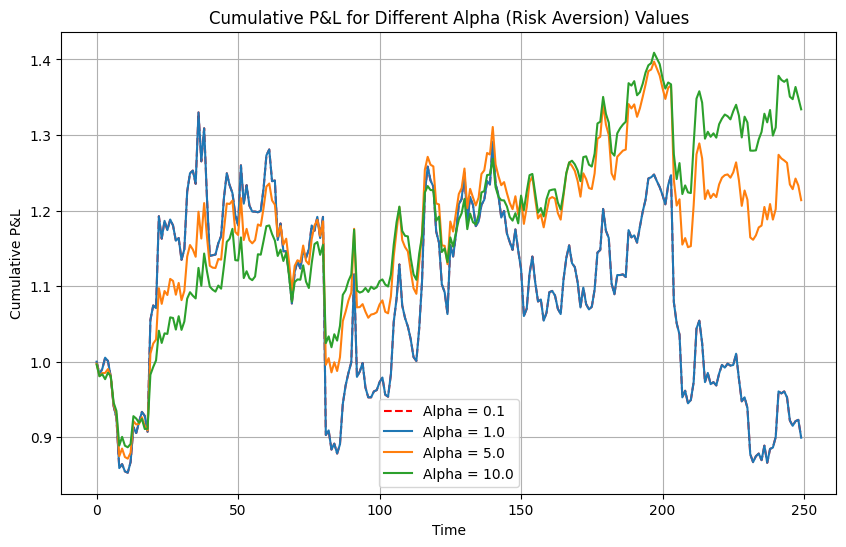

Information Ratios for different alpha values:
Alpha = 0.1, Information Ratio = 0.0073
Alpha = 1.0, Information Ratio = 0.0073
Alpha = 5.0, Information Ratio = 0.0429
Alpha = 10.0, Information Ratio = 0.0665


In [403]:
# define different alpha values
alphas = [0.1, 1.0, 5.0, 10.0] # best performing alpha is 10 because it has the greatest information ratio value compared to the other alphas
pnl_curves = []
information_ratios = []

for alpha in alphas:
    # optimize portfolio for given alpha value
    optimal_weights = mean_variance_optimization(train_returns, alpha)
    
    # calculation of portfolio perfomance with returns and information ratio 
    portfolio_returns, ir = calculate_portfolio_performance(optimal_weights, test_returns)
    
    cumulative_pnl = np.cumprod(1 + portfolio_returns)
    pnl_curves.append(cumulative_pnl)
    information_ratios.append({"alpha": alpha, "Information Ratio": ir})

plot_pnl_curves(alphas, pnl_curves)

print("Information Ratios for different alpha values:")
for info in information_ratios:
    print(f"Alpha = {info['alpha']}, Information Ratio = {info['Information Ratio']:.4f}")


### Best alpha choice
Alpha 10 has the greatest information ratio value so it is the best performing value for the portfolio
Best balance delivered from alpha 10 between returns and risks (volatility)

## Problem 2: Mean-Variance Portfolio Optimization with Leverage

Modify Problem 1 to take into account the leverage(So, we no longer have the long-only constraint). Use the best performing alpha from Problem 1.

Run portfolio optimization for range of leverages: [1, 2, 4]. Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period. Discuss which leverage performs the best. Why?

In [420]:
#Solution 2
def mean_variance_optimization_with_leverage(returns_train, alpha, leverage):

    # mean returns and covariance matrix
    mean_returns = returns_train.mean()
    cov_matrix = cp.psd_wrap(returns_train.cov())
    
    # definiton of optimization weights
    num_assets = len(mean_returns)
    weights = cp.Variable(num_assets)
    
    # portfolio objective: maximize return - risk_weight * variance
    portfolio_return = weights.T @ mean_returns
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    
    # max return - alpha * risk
    objective = cp.Maximize(portfolio_return - alpha * portfolio_risk)
    
    #  weights sum to leverage and no limit on short positions because we allowed the leverage
    constraints = [cp.sum(weights) == 1, cp.norm(weights, 1) <= leverage]   # The sum of values of weights equals leverage
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return weights.value


In [421]:
def calculate_portfolio_performance(weights, returns_test):
    portfolio_returns = np.dot(returns_test, weights)

    # calculate volatility which is standard deviation
    volatility = np.std(portfolio_returns)

    # calculate information ratio
    ir = np.mean(portfolio_returns) / volatility
    
    return portfolio_returns, ir


In [422]:
def plot_pnl_curves(leverage_values, pnl_curves):
    plt.figure(figsize=(10, 6))
    for i, leverage in enumerate(leverage_values):
        plt.plot(pnl_curves[i], label=f'Leverage = {leverage}')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.title('Cumulative P&L for Different Leverage Values')
    plt.grid(True)
    plt.show()


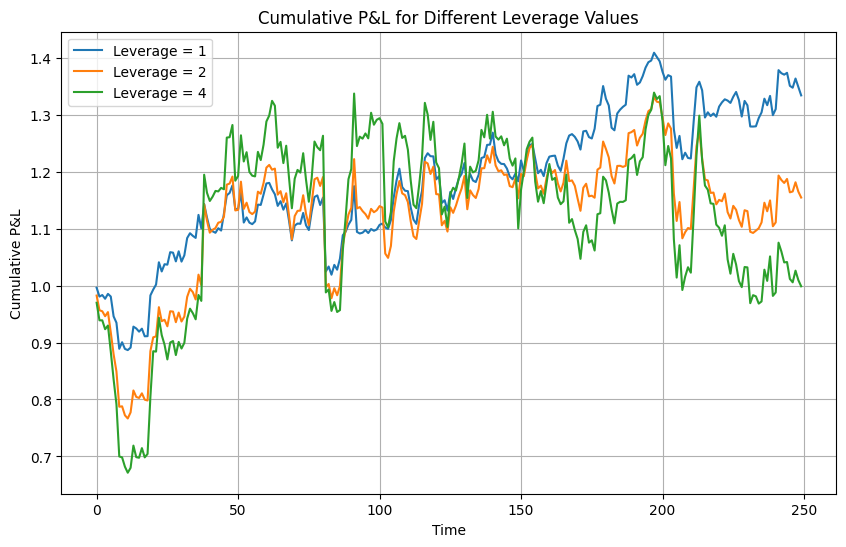

Information Ratios for different leverage values:
Leverage = 1, Information Ratio = 0.0665
Leverage = 2, Information Ratio = 0.0343
Leverage = 4, Information Ratio = 0.0217


In [423]:
leverage_values = [1, 2, 4] # leverage values
pnl_curves = []
information_ratios = []

best_alpha = 10.0

# evaluate pnl curves for each leverage value with best performing alpha
for leverage in leverage_values:
    optimal_weights = mean_variance_optimization_with_leverage(train_returns, best_alpha, leverage)
    
    portfolio_returns, ir = calculate_portfolio_performance(optimal_weights, test_returns)
    
    cumulative_pnl = np.cumprod(1 + portfolio_returns)
    pnl_curves.append(cumulative_pnl)
    information_ratios.append({"leverage": leverage, "Information Ratio": ir})

plot_pnl_curves(leverage_values, pnl_curves)

print("Information Ratios for different leverage values:")
for info in information_ratios:
    print(f"Leverage = {info['leverage']}, Information Ratio = {info['Information Ratio']:.4f}")


### Best Leverage Choice
Leverage 1 has the highest information ratio value compared to the other leverage values.
Higher information ratio indicates better performance relative to risk so leverage 1 has the best balance between risk and return
In the pnl curve (blue line), leverage 1 shows more stable upward trend compared to the other leverage values.
Even higher leverage can come up with higher returns, it has also more risk and volatility which can be seen from information ratios of leverage values of 2 and 4.
Leverage 1 has more stable returns while testing as a conclusion.

## Problem 3: Data Cleaning

Remember angle-based high-dimensional data cleaning method we discussed in the class. Assume you are given a subset of Real State Price dataset from Kaggle in file "kaggle_house_outlier.csv". For the sake of ease, you can focus only on numerical attributes.

Implement the angle-based high-dimensional data cleaning method in this dataset, where a point is defined as an outlier if the standard deviation of the all angle pairs is less than 20 (An angle is always between 0 and 360).

In [533]:
#Solution 3

# I trained the model with all train dataset but it took like 3 hours so I stopped and take a subset from the dataset
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

In [31]:
outlier_data = pd.read_csv('kaggle_house_outlier.csv')

In [32]:
selected_columns = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'YrSold'] 

In [33]:
#train_data_selected_columns = train_data[selected_columns]
#test_data_selected_columns = test_data[selected_columns]
outlier_data_selected_columns = outlier_data[selected_columns]

In [34]:
outlier_data_selected_columns.head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,YrSold
0,60,65.0,8450,196.0,706,2008
1,20,80.0,9600,0.0,978,2007
2,60,68.0,11250,162.0,486,2008
3,70,60.0,9550,0.0,216,2006
4,60,84.0,14260,350.0,655,2008


In [35]:
len(outlier_data_selected_columns), len(outlier_data_selected_columns.columns)

(450, 6)

In [540]:
print(train_data.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [36]:
print(outlier_data_selected_columns.isnull().sum())

MSSubClass      0
LotFrontage    78
LotArea         0
MasVnrArea      1
BsmtFinSF1      0
YrSold          0
dtype: int64


In [37]:
outlier_data_selected_columns_filled = outlier_data_selected_columns.fillna(outlier_data_selected_columns.mean()).copy()

In [38]:
len(outlier_data_selected_columns_filled)

450

In [39]:
def calculate_angle_three_points(p1, p2, p3):
   
    vector1 = p1 - p2
    vector2 = p3 - p2
    # vector anglge calculation with three points
    cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    # convert to degree to control later
    angle = np.degrees(np.arccos(cos_theta))
    
    return angle

In [40]:
def calculate_std_dev_of_angles_three_points(data):
   
    num_points = data.shape[0]
    outliers = []

    for i in range(num_points):
        angles = []
        
        for j in range(num_points):
            if i == j:
                continue
            for k in range(j + 1, num_points):
                if i == k or j == k:
                    continue
                
                angle = calculate_angle_three_points(data.iloc[j], data.iloc[i], data.iloc[k]) # calculate angle between three points
                angles.append(angle)
        
        std_dev = np.std(angles)
        
        if std_dev < 20: # if the stdev lower than 20, point is a outlier
            outliers.append(i)
    
    return outliers


In [41]:
print(f"Shape of train data: {outlier_data_selected_columns_filled.shape}")

Shape of train data: (450, 6)


In [43]:
sample_outlier_data_selected_columns_filled = outlier_data_selected_columns_filled.sample(n=100, random_state=42)

In [44]:
outliers_train = calculate_std_dev_of_angles_three_points(sample_outlier_data_selected_columns_filled)
print(f"Outliers in sample data (index positions): {outliers_train}")

/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_50852/501541442.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


Outliers in sample data (index positions): [11, 34, 43, 94]


In [45]:
bigger_sample_outlier_data_selected_columns_filled = outlier_data_selected_columns_filled.sample(n=100, random_state=42)

In [46]:
outliers_train = calculate_std_dev_of_angles_three_points(bigger_sample_outlier_data_selected_columns_filled)
print(f"Outliers in sample data (index positions): {outliers_train}")

/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_50852/501541442.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


Outliers in sample data (index positions): [11, 34, 43, 94]


In [47]:
outliers_train = calculate_std_dev_of_angles_three_points(outlier_data_selected_columns_filled)
print(f"Outliers in sample data (index positions): {outliers_train}")

/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_50852/501541442.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


Outliers in sample data (index positions): [75, 225, 232, 235, 249, 313, 335, 363, 430]


## Problem 4: Linear Regression for Predicting House Price 

Let's focus on the same Real State Price dataset from Kaggle (Its train and test set partitioned versions have already been provided to you). We will implement a linear regression by using sklearn to predict house price(last column) by using the following attributes:
MSSubClass, LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, YrSold.

Implement linear regression by using sklearn library. Report R2 value for test set. In order to see which attributes are significant, apply t-test. You can use statsmodels library to determine statistically-significant attributes.

In [323]:
#Solution 4
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

In [324]:
features = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'YrSold']
target = 'SalePrice'  

In [325]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [326]:
X_train.shape, y_train.shape

((1460, 6), (1460,))

In [327]:
X_test.shape, y_test.shape

((1459, 6), (1459,))

In [328]:
# Control for the null values of train set
X_train.isnull().sum()

MSSubClass       0
LotFrontage    259
LotArea          0
MasVnrArea       8
BsmtFinSF1       0
YrSold           0
dtype: int64

In [329]:
# Control for the null values of test set
X_test.isnull().sum()

MSSubClass       0
LotFrontage    227
LotArea          0
MasVnrArea      15
BsmtFinSF1       1
YrSold           0
dtype: int64

In [334]:
# fill the na values with mean
X_train.fillna(X_train.mean()).copy()
X_test.fillna(X_test.mean()).copy()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,YrSold
0,20,80.0,11622,0.0,468.0,2010
1,20,81.0,14267,108.0,923.0,2010
2,60,74.0,13830,0.0,791.0,2010
3,60,78.0,9978,20.0,602.0,2010
4,120,43.0,5005,0.0,263.0,2010
...,...,...,...,...,...,...
1454,160,21.0,1936,0.0,0.0,2006
1455,160,21.0,1894,0.0,252.0,2006
1456,20,160.0,20000,0.0,1224.0,2006
1457,85,62.0,10441,0.0,337.0,2006


In [335]:
# create the model and fit
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [336]:
# predict on test set
y_pred = linear_regression.predict(X_test)

In [337]:
y_pred.shape

(1459,)

In [338]:
# calculate r2 value
r2 = r2_score(y_test, y_pred)
print(f"R² value for the test set: {r2:.4f}")

R² value for the test set: -6.0411


In [339]:
# use stats model to see summary
X_train_stat_model = sm.add_constant(X_train)
model_fit = sm.OLS(y_train, X_train_stat_model).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     134.3
Date:                Sat, 19 Oct 2024   Prob (F-statistic):          2.22e-135
Time:                        22:18:08   Log-Likelihood:                -18222.
No. Observations:                1460   AIC:                         3.646e+04
Df Residuals:                    1453   BIC:                         3.649e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.515e+06   2.53e+06      1.390      

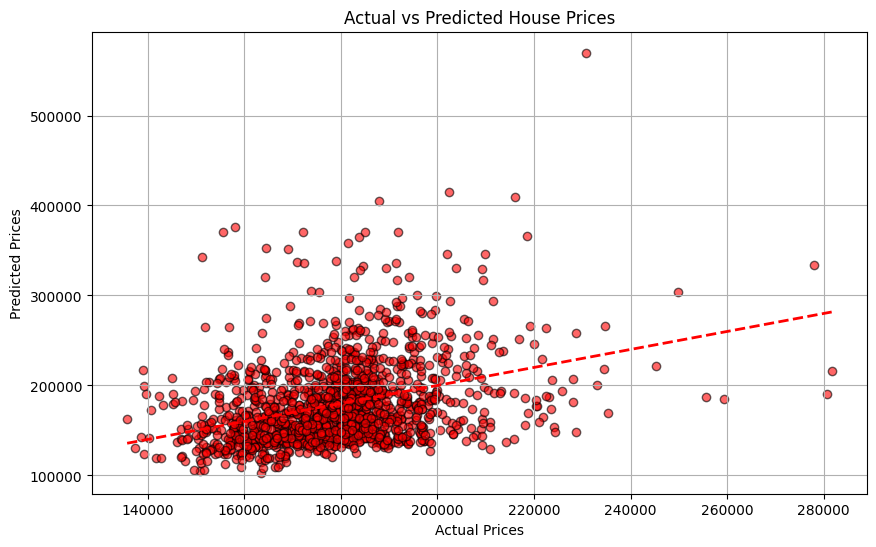

In [340]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red', edgecolor='k', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

## Challenge Problem: Risk Parity Portfolio Optimization

In this problem, we will be implementing risk-parity(equal risk contribution) portfolio optimization on S&P 500 
index constituent stocks between 2015-2017. We will be training the optimizer between 2015-2016, and testing it on 
between 2016 and 2017.

We assume that stocks can only be long, and all portfolio should be allocated to stocks (We cannot hold cash).

You need to use cvxpy library to formulate and solve the corresponding optimization problem. Similar to previous 
questions, you can obtain the stock price data by Yahoo Finance library(yfinance).

Plot P&L curve for testing period. Calculate Information Ratio based on daily returns for the same testing period. 

---

In [285]:
def download_and_prepare_data(tickers, train_start, train_end, test_start, test_end):
    train_data = yfinance.download(tickers, start=train_start, end=train_end)['Close']
    test_data = yfinance.download(tickers, start=test_start, end=test_end)['Close']

    train_data = train_data.fillna(train_data.mean())
    test_data = test_data.fillna(test_data.mean())

    train_returns = train_data.pct_change().dropna()
    test_returns = test_data.pct_change().dropna()

    return train_returns, test_returns

In [286]:
def naive_risk_parity_optimization(returns):
    cov_matrix = returns.cov().values # covariance matrix
    num_assets = cov_matrix.shape[0]

    regularization = 1e-2 # for positive definite 
    # without regularization, I am getting the problem is semi-definite so cvxpy didn't solve the problem
    cov_matrix += np.eye(num_assets) * regularization

    weights = cp.Variable(num_assets) # convert to cvxpy variable 

    # minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)

    # constraints as weights sum to 1 (full investment on portfolio)
    # all weights should be non negative (long position)
    constraints = [
        cp.sum(weights) == 1,
        weights >= 0
    ]

    objective = cp.Minimize(portfolio_variance)
    problem = cp.Problem(objective, constraints)
    result = problem.solve()

    if result == float('inf') or result == float('-inf'):
        print("The optimization problem was infeasible.")
    else:
        print("Optimal Weights:", weights.value)

    return weights.value

In [287]:
def plot_pnl_curve(portfolio_returns):
    cumulative_returns = np.cumprod(1 + portfolio_returns)

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Naive Risk Parity Portfolio')
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.title('P&L Curve for Naive Risk Parity Portfolio')
    plt.legend()
    plt.grid(True)
    plt.show()

In [288]:
def calculate_information_ratio(portfolio_returns):
    mean_return = np.mean(portfolio_returns)
    volatility = np.std(portfolio_returns)
    information_ratio = mean_return / volatility
    return information_ratio

In [289]:
with open("sp500tickers.txt", 'r') as file:
    tickers = [line.strip() for line in file if line.strip() != 'LRCX']  # Remove delisted ticker

In [290]:
train_start_date = "2015-01-01"
train_end_date = "2016-12-31"
test_start_date = train_end_date
test_end_date = "2017-12-31"

In [293]:
train_returns, test_returns = download_and_prepare_data(tickers, train_start_date, train_end_date, test_start_date, test_end_date)

[*********************100%***********************]  479 of 479 completed
[*********************100%***********************]  479 of 479 completed


In [294]:
optimal_weights = naive_risk_parity_optimization(train_returns)

Optimal Weights: [6.44679146e-04 8.52389466e-05 2.20522833e-03 2.26254042e-03
 1.23704161e-03 4.74019616e-03 1.75200718e-03 1.03719043e-03
 5.34635568e-04 1.28902433e-03 1.94641022e-03 3.15634066e-05
 3.95664748e-03 3.86122722e-03 7.98484805e-04 2.75012583e-03
 1.78623138e-03 2.93042180e-03 3.11311629e-03 5.95225135e-04
 4.53724193e-04 1.24701167e-03 1.18949257e-03 3.50701927e-03
 1.66211291e-03 5.63013347e-04 9.32030546e-03 1.05239564e-24
 1.92533426e-03 5.60576347e-04 9.36980373e-25 2.28395710e-03
 1.82923332e-03 2.00277448e-03 1.86713728e-03 2.53191506e-03
 7.03962879e-04 6.05717786e-25 2.11714169e-03 1.89732877e-03
 8.02824415e-25 2.62792998e-03 3.84042183e-03 3.33399367e-03
 8.08717062e-25 1.85115715e-03 4.44022937e-03 8.99521221e-04
 3.54511847e-03 3.73166673e-03 1.56817720e-03 2.69384471e-04
 1.77604093e-03 3.14630962e-03 2.75142166e-03 2.82089475e-03
 2.89787586e-03 3.67983378e-25 3.36628174e-03 9.46735600e-04
 3.79523427e-03 9.71695853e-04 1.21279599e-03 9.65849323e-04
 1.1244

In [295]:
portfolio_returns = test_returns @ optimal_weights

In [322]:
print(portfolio_returns)

Date
2017-01-04 00:00:00+00:00    0.008294
2017-01-05 00:00:00+00:00   -0.001419
2017-01-06 00:00:00+00:00    0.002721
2017-01-09 00:00:00+00:00   -0.005565
2017-01-10 00:00:00+00:00    0.001190
                               ...   
2017-12-22 00:00:00+00:00    0.001297
2017-12-26 00:00:00+00:00    0.000677
2017-12-27 00:00:00+00:00    0.001308
2017-12-28 00:00:00+00:00    0.002417
2017-12-29 00:00:00+00:00   -0.004012
Length: 250, dtype: float64


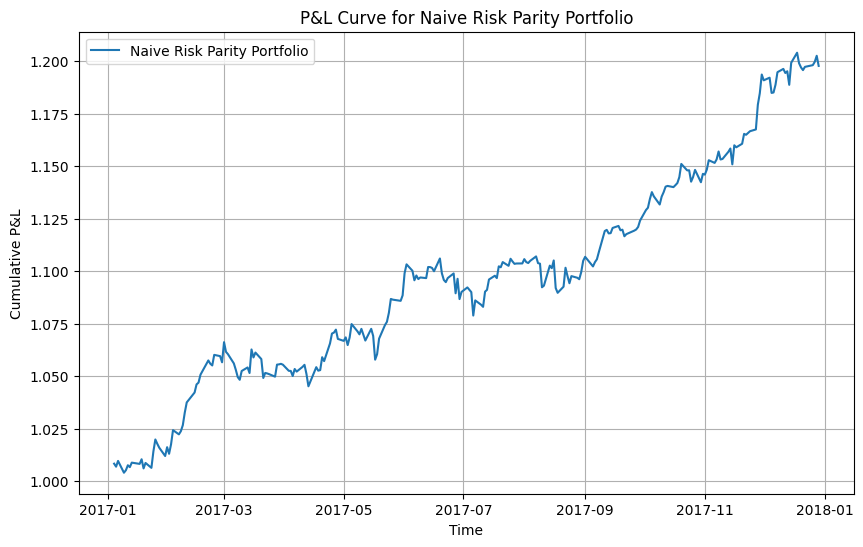

In [296]:
plot_pnl_curve(portfolio_returns)

In [297]:
information_ratio = calculate_information_ratio(portfolio_returns)
print("Information Ratio:", information_ratio)

Information Ratio: 0.18937941726680682


In [316]:
subset_size = 10  # trying to solve original mariginal contributions with smaller size of the data
subset_tickers = train_returns.columns[:subset_size]

In [317]:
train_returns_subset = train_returns[subset_tickers]
test_returns_subset = test_returns[subset_tickers]

In [319]:
# With marginal contributions, I got an error of problem is not proper for the convex form so I tried and solve with naive form
def risk_parity_optimization(returns):
    cov_matrix = returns.cov().to_numpy()
    num_assets = cov_matrix.shape[0]

    regularization = 1e-2
    cov_matrix += np.eye(num_assets) * regularization

    weights = cp.Variable(num_assets)

    portfolio_variance = cp.quad_form(weights, cov_matrix)
    marginal_risk_contributions = cov_matrix @ weights
    risk_contributions = cp.multiply(weights, marginal_risk_contributions)

    target_risk_contribution = portfolio_variance / num_assets

    objective = cp.Minimize(cp.sum(cp.abs(risk_contributions - target_risk_contribution)))

    constraints = [
        cp.sum(weights) == 1,
        weights >= 0
    ]

    problem = cp.Problem(objective, constraints)
    result = problem.solve()

    if result == float('inf') or result == float('-inf'):
        print("The optimization problem was infeasible.")
    else:
        print("Optimal Weights:", weights.value)

    return weights.value


In [320]:
optimal_weights_subset = risk_parity_optimization(train_returns_subset)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var973 @ [[0.01 0.00 ... 0.00 0.00]
 [0.00 0.01 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.01 0.00]
 [0.00 0.00 ... 0.00 0.01]] @ var973